In [1]:
!git clone https://github.com/RIPS-2024-Aerospace/Aerospace-Project.git

Cloning into 'Aerospace-Project'...
remote: Enumerating objects: 437, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 437 (delta 112), reused 83 (delta 55), pack-reused 269
Receiving objects: 100% (437/437), 30.21 MiB | 7.69 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [12]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

np.random.seed(29)

%run "/content/Aerospace-Project/DiffusionLunarKF.ipynb"
%run "/content/Aerospace-Project/CentralizedLunarKF.ipynb"
%run "/content/Aerospace-Project/FilterComparison.ipynb"

In [3]:
C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
C_ckf = 0.2*np.ones((5,5))
D = np.array([[3,3,3,3,3], [3, 3, 0, 0,0], [3, 0, 3, 0,0], [3,0,0, 3,0],[3,0,0,0,3]])
D_ckf = 3*np.ones((5,5))
n = len(C)

true_biases = np.array([[np.random.normal(0,np.sqrt(12/(c**2))) for _ in range(n)]]).T
true_drifts = np.array([[np.random.normal(0,np.sqrt(0.1/(c**2))) for _ in range(n)]]).T
# true_drifts = np.array([[0 for _ in range(n)]]).T

F = np.array([[1,dt],[0,1]])
F_full = np.kron(np.eye(n),F)

def get_station_truth(x,id):
    return np.array([[x[2*id][0]],[x[2*id+1][0]]])

x = c*np.vstack(tuple([np.array([true_biases[i],true_drifts[i]]) for i in range(n)]))

# random initial estimates for each node

x0 = [np.array([[np.random.normal(0,np.sqrt(12))],[np.random.normal(0,np.sqrt(0.1))]]) for i in range(n)]


P = [100*np.copy(R(1)) for _ in range(n)]

stations = [Station(i) for i in range(n)]
stations_ckf = [Station(i) for i in range(n)]
filter_initialize(stations,D,x0,P)

filter_initialize(stations_ckf,D_ckf,x0,P)


In [4]:
iterations = 200

# num_msmts = np.random.randint(0,10,(iterations,5))
num_msmts = np.array([[0,2,2,2,2] for _ in range(iterations)])

filter_outputs = run_both_filters(iterations, num_msmts,C,F_full,stations,stations_ckf, x, convergence = None)

errors_df,errors_cf,P_hist_cf,P_hist_df,truth,measurements = filter_outputs

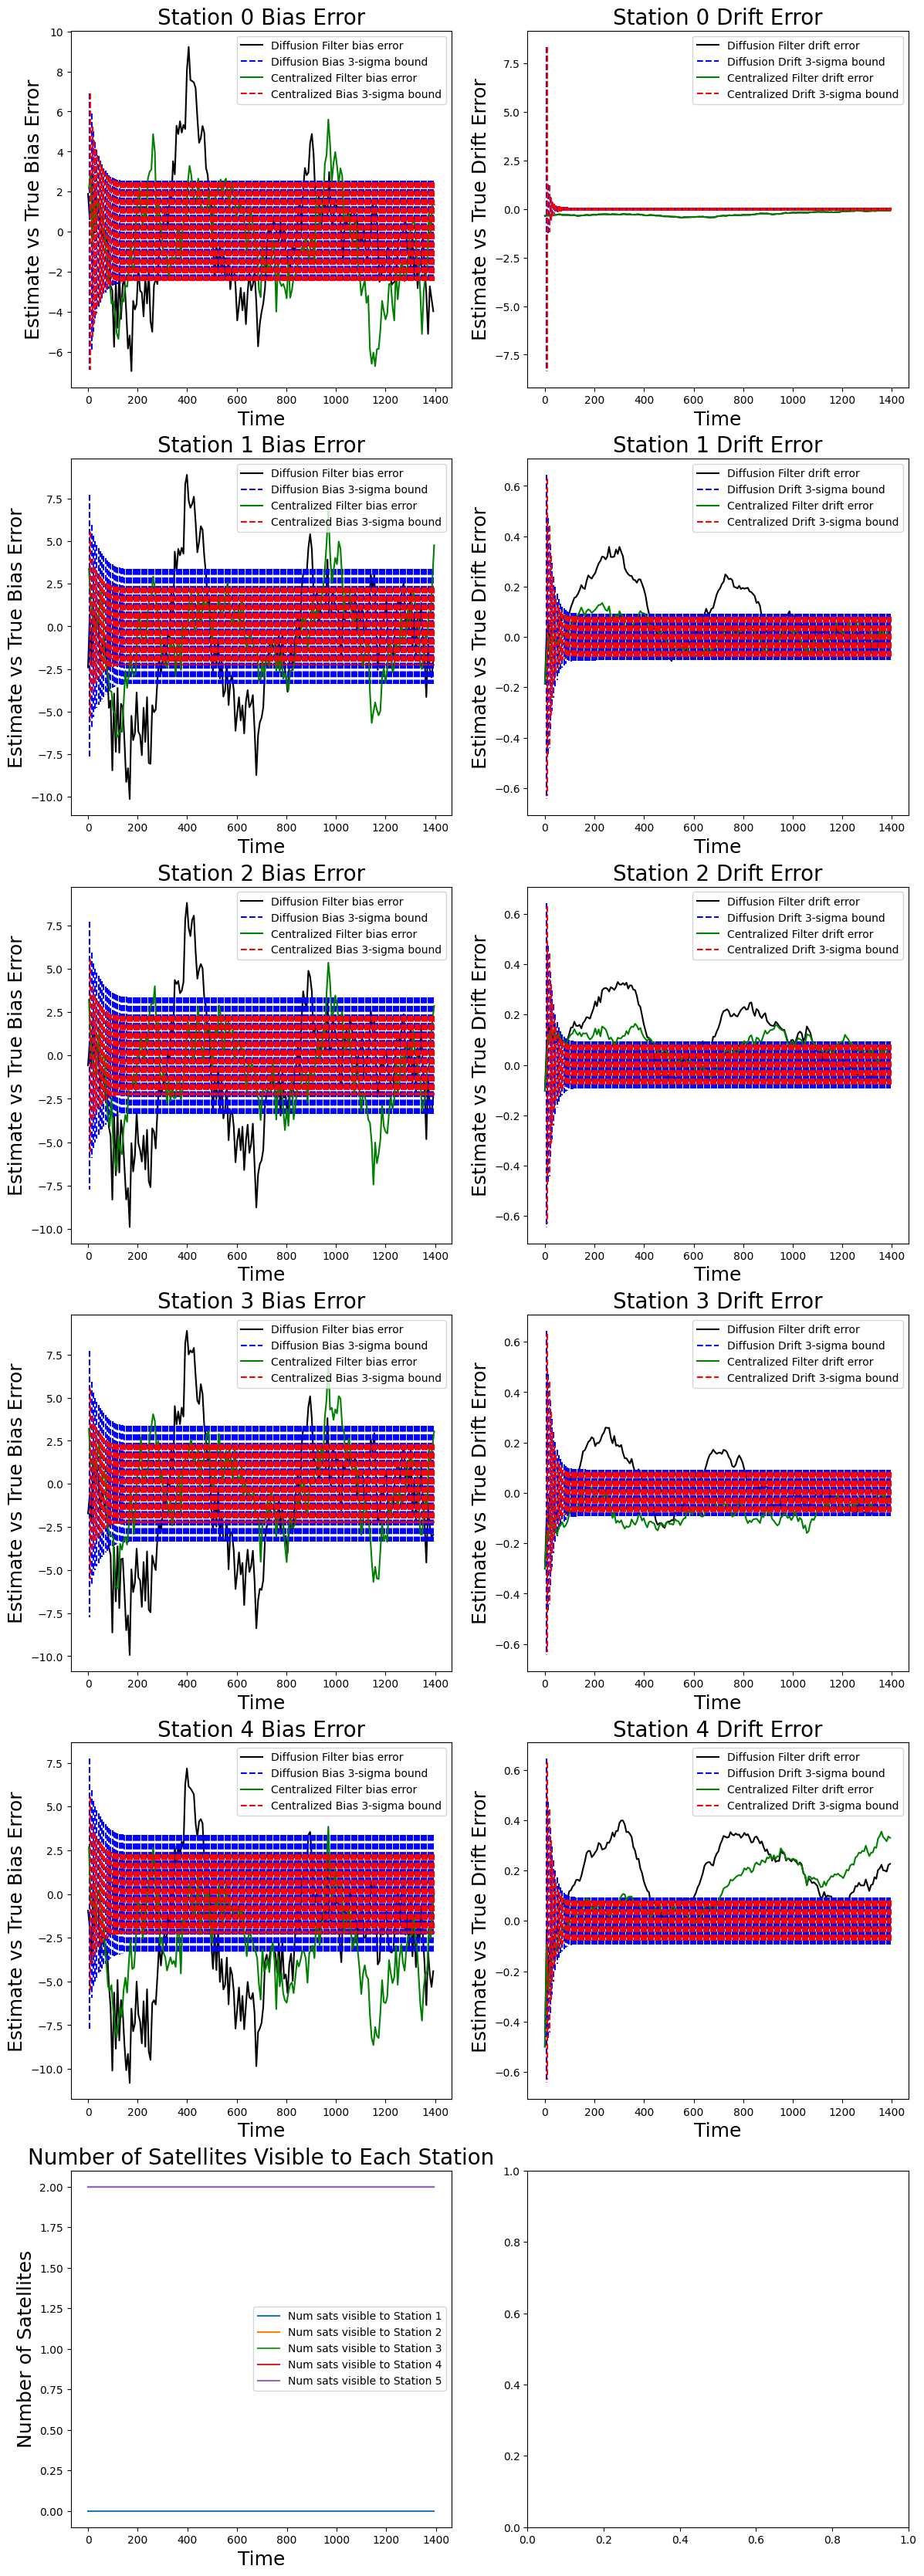

In [5]:
#Number of stations whose plots we are looking at
k = [0,1,2,3,4]

num_rows = len(k)
fig,axs = plt.subplots(num_rows+1,2, figsize=(14, 7*(num_rows+1)))
t_hist = np.arange(0, dt*iterations, dt)
t_hist_cf = np.arange(3.5, dt*iterations, dt)


for inx,i in enumerate(k):
    #Diffusion Filter Error Plots
    axs[inx][0].plot(t_hist, errors_df[:, i,0,0], 'k', label = "Diffusion Filter bias error")
    bias_cov = 3*np.sqrt(P_hist_df[:, i,0,0])
    axs[inx][0].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([bias_cov[1], -bias_cov[1]]), 'b--', label = "Diffusion Bias 3-sigma bound")
    axs[inx][0].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([bias_cov[2:], -bias_cov[2:]]), 'b--')

    axs[inx][0].plot(t_hist_cf, errors_cf[:, i,0,0], 'g', label = "Centralized Filter bias error")
    bias_cov = 3*np.sqrt(P_hist_cf[:, i,0,0])
    axs[inx][0].plot(np.vstack([t_hist_cf[1], t_hist_cf[1]]), np.vstack([bias_cov[1], -bias_cov[1]]), 'r--', label = "Centralized Bias 3-sigma bound")
    axs[inx][0].plot(np.vstack([t_hist_cf[2:], t_hist_cf[2:]]), np.vstack([bias_cov[2:], -bias_cov[2:]]), 'r--')

    axs[inx][0].legend()
    axs[inx][0].set_title("Station "+str(i)+" Bias Error", fontsize = 20)
    axs[inx][0].set_xlabel("Time", fontsize = 18)
    axs[inx][0].set_ylabel("Estimate vs True Bias Error", fontsize = 18)

    axs[inx][1].plot(t_hist, errors_df[:, i,1,0], 'k', label = "Diffusion Filter drift error")
    drift_cov = 3*np.sqrt(P_hist_df[:, i,1,1])
    axs[inx][1].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([drift_cov[1], -drift_cov[1]]), 'b--', label = "Diffusion Drift 3-sigma bound")
    axs[inx][1].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([drift_cov[2:], -drift_cov[2:]]), 'b--')

    axs[inx][1].plot(t_hist, errors_cf[:, i,1,0], 'g', label = "Centralized Filter drift error")
    drift_cov = 3*np.sqrt(P_hist_cf[:, i,1,1])
    axs[inx][1].plot(np.vstack([t_hist_cf[1], t_hist_cf[1]]), np.vstack([drift_cov[1], -drift_cov[1]]), 'r--', label = "Centralized Drift 3-sigma bound")
    axs[inx][1].plot(np.vstack([t_hist_cf[2:], t_hist_cf[2:]]), np.vstack([drift_cov[2:], -drift_cov[2:]]), 'r--')

    axs[inx][1].legend()
    axs[inx][1].set_title("Station "+str(i)+" Drift Error", fontsize = 20)
    axs[inx][1].set_xlabel("Time", fontsize = 18)
    axs[inx][1].set_ylabel("Estimate vs True Drift Error", fontsize = 18)

for i in range(n):
    axs[-1][0].plot(t_hist,num_msmts[:,i], label = f"Num sats visible to Station {i+1}")

axs[-1][0].legend()
axs[-1][0].set_title("Number of Satellites Visible to Each Station", fontsize = 20)
axs[-1][0].set_xlabel("Time", fontsize = 18)
axs[-1][0].set_ylabel("Number of Satellites", fontsize = 18)



plt.show()

Monte Carlo to find the Covariance if the filter

In [10]:
# defined if function is placed in seperate file
import numpy as np
import math

def sample_cov(C):
    sample_cov = 0
    iters = 100 # monte carlo iters

    for j in range(iters):
      # Variables
      T_c = 0.00000009775
      f_L1 = 1575420000
      N_i = 4
      CN0 = 15
      B_pll = 0.5
      B_fe = 26000000
      T = 0.020
      d = 0.3
      pi = math.pi
      c = 299792458
      B_dll = 0.5
      dt = 7
      sigma_uere = 0 # can't find a value for this

      # Values from random table in Source 31
      # h_0 = 1.4*(10**(-22))
      # h_m1 = 2.3*(10**(-26))
      # h_m2 = 3.3*(10**(-31))

      # Values from sample clocks in Source 30
      h_0 = 1.8*(10**(-21))
      h_m1 = 6.492*(10**(-22))
      h_m2 = 1.37*(10**(-24))

      e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*h_m2*(pi**2)*(dt**3)
      e2 = 2*h_m1*dt + h_m2*((pi*dt)**2)
      e3 = ((h_0/(2*dt))+ 2*h_m1 + (8/3)*(pi*pi)*h_m2*dt)

      Q = (c**2)*np.array([[e1,e2],[e2,e3]])

      s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0)))
      pr_var = ((c*T_c)**2)*s_dll+ sigma_uere

      s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0)))
      prr_var = ((c**2)/((2*pi*f_L1 * T)**2)) * (s_pll)

      R = lambda N : np.kron(np.eye(N),np.array([[pr_var,0],[0,prr_var]]))
      R_cf = lambda num_msmts: np.kron(np.eye(sum(num_msmts)),R(1))

      measure_noise = lambda num_msmts : np.linalg.cholesky(R_cf(num_msmts)) @ np.random.normal(np.array([[0 for _ in range(2*sum(num_msmts))]]).T)
      sigma_j = 10**(-16)

      # C = np.array([[0.3,0,0.2,0.5,0], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
      D = np.array([[3,3,3,3,3], [3, 3, 0, 0,0], [3, 0, 3, 0,0], [3,0,0, 3,0],[3,0,0,0,3]])

      n = len(C)

      true_biases = np.array([[np.random.normal(0,np.sqrt(12/(c**2))) for _ in range(n)]]).T
      true_drifts = np.array([[np.random.normal(0,np.sqrt(0.1/(c**2))) for _ in range(n)]]).T
      # true_drifts = np.array([[0 for _ in range(n)]]).T

      F = np.array([[1,dt],[0,1]])
      F_full = np.kron(np.eye(n),F)

      Q_10x10=np.kron(np.eye(5), Q)

      def get_station_truth(x,id):
        return np.array([[x[2*id][0]],[x[2*id+1][0]]])

      x = c*np.vstack(tuple([np.array([true_biases[i],true_drifts[i]]) for i in range(n)]))

      # Random initial estimates for each node
      x0 = [np.array([[np.random.normal(0,np.sqrt(12))],[np.random.normal(0,np.sqrt(0.1))]]) for i in range(n)]
      x0_cf = np.vstack(tuple(x0))
      # x0 = [np.array([[0],[0]]) for _ in range(n)]

      P = [100*np.copy(R(1)) for _ in range(n)]
      P_prev = np.block([[P[i] if i==j else np.zeros((2,2)) for j in range(n)] for i in range(n)])

      stations = [Station(i) for i in range(n)]

      filter_initialize(stations,D,x0,P)

      kf = KalmanFilter(A = F_full, H = H_cf, Q = Q_10x10, R = R_cf, P = P_prev, x0 = x0_cf)
      # For the first iteration these are our cross_links
      iterations = 50

      # Number of visible satellites
      num_msmts = np.full((iterations, 5), 2)
      # num_msmts = np.random.randint(0,10,(iterations,5))

      filter_outputs = run_both_filters(iterations, num_msmts,C,F_full,stations,stations_ckf, x, convergence = None)

      errors_df,errors_cf,P_hist_cf,P_hist_df,truth,measurements = filter_outputs

      # expectation of full state covariance (without normalizing)
      errors_flat = errors_df[-1].flatten()
      e = np.outer(errors_flat, errors_flat)
      sample_cov = sample_cov + e

    sample_cov = sample_cov / iters
    print("The full state covariance by sampling is", sample_cov) # sample covaraiance


    diagonal_entries = np.diag(sample_cov) # 3 sigma bound
    result = 3 * np.sqrt(diagonal_entries)
    print("3-sigma bound is", result)

    return sample_cov, result

# Example usage
C = np.array([[0.3, 0, 0.2, 0.5, 0], [0.5, 0.5, 0, 0, 0], [0.5, 0, 0.5, 0, 0], [0.5, 0, 0, 0.5, 0], [0.5, 0, 0, 0, 0.5]])
sample_cov, result = sample_cov(C)


The full state covariance by sampling is [[ 5.86449075e+00 -1.05911432e-01  3.30000347e+00  3.35676045e-02
   2.99385308e+00  4.43150116e-02  2.78979692e+00  8.20595973e-02
   3.20457157e+00  3.46619927e-02]
 [-1.05911432e-01  1.04484399e-02  2.69519742e-02 -3.49183572e-03
   3.82805548e-02 -4.02450372e-03  4.34090211e-02 -5.59871305e-03
   3.91020906e-02 -4.61848083e-03]
 [ 3.30000347e+00  2.69519742e-02  7.25471599e+00 -1.25539434e-01
   5.89564635e+00 -6.23684992e-02  5.99287332e+00 -4.08203996e-02
   6.61854587e+00 -7.00627320e-02]
 [ 3.35676045e-02 -3.49183572e-03 -1.25539434e-01  1.59354921e-02
  -6.35735556e-02  6.86655443e-03 -6.54544732e-02  4.70840983e-03
  -7.00297809e-02  6.43359851e-03]
 [ 2.99385308e+00  3.82805548e-02  5.89564635e+00 -6.35735556e-02
   6.44432071e+00 -1.06202123e-01  5.34819164e+00 -2.39419152e-02
   6.22348613e+00 -7.82263502e-02]
 [ 4.43150116e-02 -4.02450372e-03 -6.23684992e-02  6.86655443e-03
  -1.06202123e-01  1.33563238e-02 -3.33107220e-02  1.78646

use the sample covariance to minimize bhattacharya distance